In [160]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

root_dir = '/kaggle/input/tgs-salt-identification-challenge/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
train_df = pd.read_csv(root_dir+'train.csv')
print(f'\nTraining:\n{train_df.head()}')

depth_df = pd.read_csv(root_dir+'depths.csv')
print(f'Depths:\n{depth_df.head()}')


/kaggle/input/tgs-salt-identification-challenge/depths.csv
/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv
/kaggle/input/tgs-salt-identification-challenge/train.zip
/kaggle/input/tgs-salt-identification-challenge/competition_data.zip
/kaggle/input/tgs-salt-identification-challenge/test.zip
/kaggle/input/tgs-salt-identification-challenge/train.csv
/kaggle/input/tgs-salt-identification-challenge/flamingo.zip

Training:
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
Depths:
           id    z
0  4ac19fb269  306
1  1825fadf99  157
2  f59821d067  305
3  5b435fad9d  503
4  e340e7bfca  783


In [2]:
from zipfile import ZipFile

output_dir = '/kaggle/working/'
train_zip = 'train.zip'

with ZipFile(root_dir+train_zip, 'r') as z:
    z.extractall(path=output_dir)
z.close()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


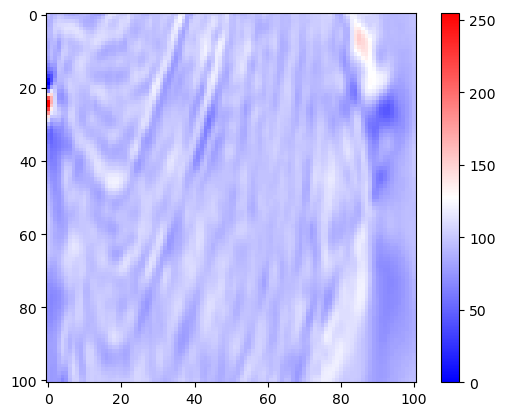

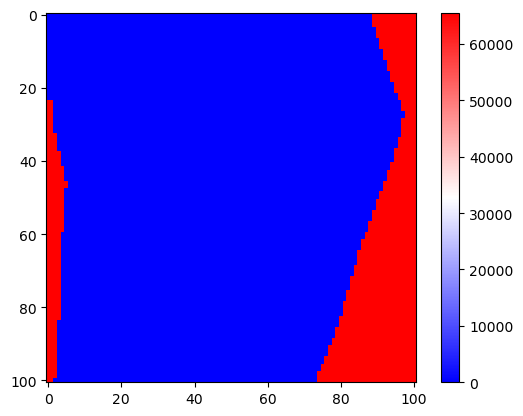

In [161]:
import matplotlib.pyplot as plt

img_dir = '/kaggle/working/images/'
mask_dir = '/kaggle/working/masks/'

train_df = pd.read_csv(root_dir+'train.csv')

id_df = train_df['id']
img_id = id_df.iloc[np.random.randint(0, len(id_df))]

img = Image.open(f'{img_dir}{img_id}.png')
mask = Image.open(f'{mask_dir}{img_id}.png')

img_np = np.mean(np.array(img), axis=-1)

plt.figure()
plt.imshow(img_np, cmap='bwr')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.array(mask), cmap='bwr')
plt.colorbar()
plt.show()

In [128]:
class SeismicSalt(Dataset):
    def __init__(self, img_dir, mask_dir, info_df, tsfm=None) -> None:
        self.df = info_df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.tsfm = tsfm

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> tuple:
        sample_id = self.df.iloc[idx]['id']
        
        img = Image.open(f'{img_dir}{sample_id}.png')
        mask = Image.open(f'{mask_dir}{sample_id}.png')
        
        if self.tsfm is not None:
            img = self.tsfm(img)
            mask = self.tsfm(mask)/65535
        
        mask_2ch = torch.zeros((2, 101, 101))
        mask_2ch[0, :, :] = torch.zeros_like(mask[0, :, :])
        mask_2ch[1, :, :] = mask[0, :, :]
        
        return img.to(device), mask_2ch.to(device)


In [67]:
import torch.nn as nn
import torch.functional as F
import torch

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sz=4, stride=2, padding=1, normalise=True):
        super().__init__()
        self.normalise = normalise

        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_sz, stride, padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(x)
        x = self.conv(x)

        if self.normalise:
            x = self.batch_norm(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sz=4, stride=2, padding=1, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout

        self.relu = nn.ReLU(inplace=True)
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_sz, stride, padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=0.5, inplace=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.conv_transpose(x)
        x = self.batch_norm(x)

        if self.use_dropout:
            x = self.dropout(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.encoder2 = EncoderBlock(32, 64)
        self.encoder3 = EncoderBlock(64, 101)
        self.encoder4 = EncoderBlock(101, 101)
        self.encoder5 = EncoderBlock(101, 101, normalise=False)

        self.decoder5 = DecoderBlock(101, 101, use_dropout=True)
        self.decoder4 = DecoderBlock(2*101, 101, use_dropout=True)
        self.decoder3 = DecoderBlock(2*101, 64, kernel_sz=3, padding=0)
        self.decoder2 = DecoderBlock(2*64, 32)
        self.decoder1 = nn.ConvTranspose2d(2*32, 2, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        # encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)

        d5 = self.decoder5(e5)
        d5 = torch.cat([d5, e4], dim=1)

        d4 = self.decoder4(d5)
        d4 = torch.cat([d4, e3], dim=1)
        
        d3 = self.decoder3(d4)
        d3 = torch.cat([d3, e2], dim=1)

        d2 = self.decoder2(d3)
        d2 = torch.cat([d2, e1], dim=1)

        d1 = self.decoder1(d2)
        return torch.sigmoid(d1)

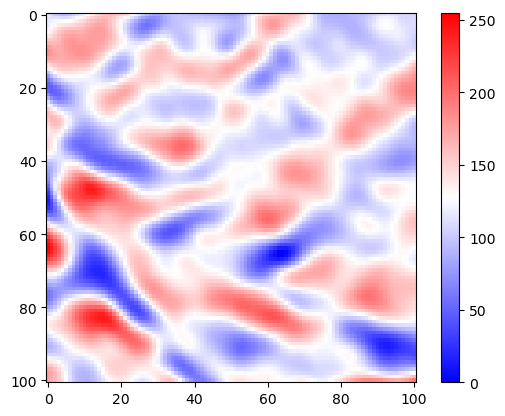

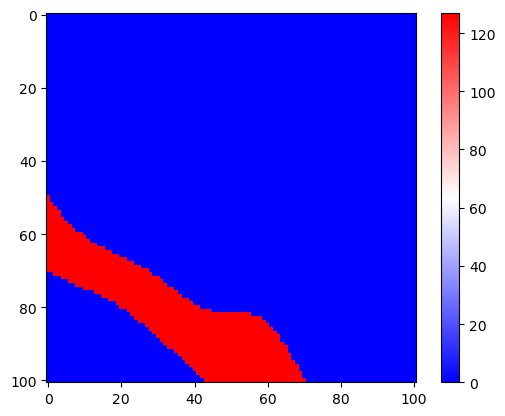

In [129]:
batch_size_train = 32
batch_size_test = 16
# standard torchvision normalization
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                     std=[0.229, 0.224, 0.225])
# tsfm = transforms.Compose([transforms.ToTensor(), normalize])

img_dir = '/kaggle/working/images/'
mask_dir = '/kaggle/working/masks/'
info_df = pd.read_csv(root_dir+'train.csv')


tsfm = transforms.Compose([transforms.ToTensor()])
dataset = SeismicSalt(img_dir, mask_dir, info_df, tsfm=tsfm)

train_sz = int(0.8 * len(dataset))
test_sz = len(dataset) - train_sz
train_data, test_data = torch.utils.data.random_split(dataset, [train_sz, test_sz])

train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)


img, mask = train_data.__getitem__(10)
mask = torch.mean(mask, axis=0)
img = torch.mean(img, axis=0)

mask = transforms.ToPILImage()(mask)
img = transforms.ToPILImage()(img)

plt.figure()
plt.imshow(img, cmap='bwr')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(mask, cmap='bwr')
plt.colorbar()
plt.show()

In [137]:
import gc

epochs = 30

model = UNet().to(device)

criterion = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), betas=(0.5, 0.999), amsgrad=True)

for epoch in range(epochs):
    avg_train_loss = 0
    
    for batch_idx, (x, mask) in enumerate(train_loader):
        model.train()
        
        pred = model(x)
        loss = criterion(pred, mask)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        avg_train_loss += loss.cpu().detach()
        
    avg_val_loss = 0
    for batch_idx, (x, mask) in enumerate(test_loader):
        model.eval()
        pred = model(x)
        loss = criterion(pred, mask)

        avg_val_loss += loss
        
    print(f'Epoch nr. {epoch + 1:02d}/{epochs} --- Training loss: {avg_train_loss/len(train_loader):.4f} --- Validation loss: {avg_val_loss/len(test_loader):.4f}')

Epoch nr. 01/30 --- Training loss: 0.3565 --- Validation loss: 1.3237
Epoch nr. 02/30 --- Training loss: 0.2137 --- Validation loss: 0.3281
Epoch nr. 03/30 --- Training loss: 0.1894 --- Validation loss: 0.3169
Epoch nr. 04/30 --- Training loss: 0.1679 --- Validation loss: 0.2376
Epoch nr. 05/30 --- Training loss: 0.1643 --- Validation loss: 0.5523
Epoch nr. 06/30 --- Training loss: 0.1474 --- Validation loss: 0.1746
Epoch nr. 07/30 --- Training loss: 0.1408 --- Validation loss: 0.4850
Epoch nr. 08/30 --- Training loss: 0.1333 --- Validation loss: 0.1373
Epoch nr. 09/30 --- Training loss: 0.1199 --- Validation loss: 0.2205
Epoch nr. 10/30 --- Training loss: 0.1164 --- Validation loss: 0.1418
Epoch nr. 11/30 --- Training loss: 0.1065 --- Validation loss: 0.2147
Epoch nr. 12/30 --- Training loss: 0.0961 --- Validation loss: 0.2406
Epoch nr. 13/30 --- Training loss: 0.0973 --- Validation loss: 0.1522
Epoch nr. 14/30 --- Training loss: 0.0765 --- Validation loss: 0.1236
Epoch nr. 15/30 --- 

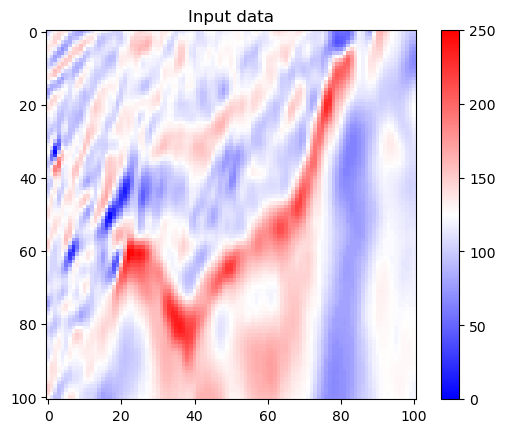

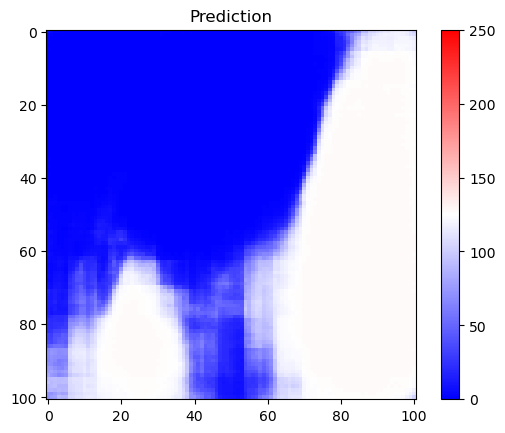

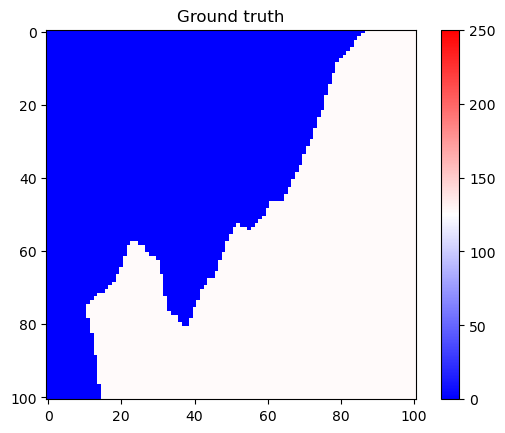

In [158]:
for batch_idx, (x, mask) in enumerate(test_loader):
    model.eval()
    pred = model(x)
    loss = criterion(pred, mask)
    break

mask_pred = pred[0].cpu().detach()
mask_pred = torch.mean(mask_pred, axis=0)

mask_true = torch.mean(mask[0], axis=0)
mask_true = transforms.ToPILImage()(mask_true)

x_t = torch.mean(x[0], axis=0)
x_t = transforms.ToPILImage()(x_t)

mask_pred = transforms.ToPILImage()(mask_pred)

plt.figure()
plt.imshow(x_t, cmap='bwr', vmax=250, vmin=0)
plt.colorbar()
plt.title('Input data')
plt.show()

plt.figure()
plt.imshow(mask_pred, cmap='bwr', vmax=250, vmin=0)
plt.colorbar()
plt.title('Prediction')
plt.show()

plt.figure()
plt.imshow(mask_true, cmap='bwr', vmax=250, vmin=0)
plt.title('Ground truth')
plt.colorbar()
plt.show()